In [110]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [111]:
# # you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

# if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
#     raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

# BES_code_folder   = "../BES_analysis_code/" # we should be here!
# BES_small_data_files = BES_code_folder + "small data files" + os.sep
# if not os.path.exists( BES_small_data_files ):
#     os.makedirs( BES_small_data_files )

# # we should create these if they don't already exist
# BES_data_folder   = "../BES_analysis_data/"
# if not os.path.exists( BES_data_folder ):
#     os.makedirs( BES_data_folder )

# BES_output_folder = "../BES_analysis_output/"
# if not os.path.exists( BES_output_folder ):
#     os.makedirs( BES_output_folder )
    
# BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

# BES_R_data_files = BES_data_folder + "R_data" + os.sep
# if not os.path.exists( BES_R_data_files ):
#     os.makedirs( BES_R_data_files )


In [112]:
# dataset_name = "W13_comb"

In [113]:
# %%time

# manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

# data_subfolder = BES_data_folder + dataset_name + os.sep

# dataset_filename = manifest["Stata_Filename"].values[0]
# # dataset_description = manifest["Friendlier_Description"].values[0]
# # dataset_citation = manifest["Citation"].values[0]
# # dataset_start = manifest["Date_Start"].values[0]
# # dataset_stop = manifest["Date_Stop"].values[0]
# # dataset_wave = manifest["Wave No"].values[0]

# BES_Panel = pd.read_msgpack( data_subfolder + dataset_filename.replace(".dta",".msgpack") )
# print("BES_Panel", BES_Panel.shape )

# ####

# BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
# print("BES_numeric",  BES_numeric.shape )

# var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
# var_type.set_index("Unnamed: 0", inplace=True)
# print("var_type",  var_type.shape )

# fname = data_subfolder + "cat_dictionary.pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )
    
# ####

# BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
# print("BES_non_numeric",  BES_non_numeric.shape )

# BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
# print("BES_reduced",  BES_reduced.shape )

# BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
# print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

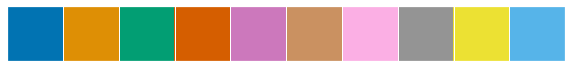

In [114]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [115]:
dataset_name = "W13_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
           "BESnumeric",
           "BES_reduced",
#            "BESnumeric"
          ]

In [116]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [117]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.


var_type (5173, 12)


In [118]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [119]:
[x for x in BES_Panel.columns if "imm" in x.lower()]
# immigEcon, immigCultural 

# immigrationLevel SINGLE CHOICE W4W6
# immigContributeTake SCALE W7W8

# immigSelf W7W8W9W10W11W12W13
# immig<parties> W7W8W9W10W11W12W13

# immigrantsWelfareState DYNAMIC GRIDW1W2W3W4W7W8W10W11Topup
# immigEcon W1W2W3W4W6W7W8W10W11W13
# immigCultural W1W2W3W4W6W7W8W10W11W13

# changeImmig The level of immigration  W1W2W3W4W7W8W10W11
# changeImmigLab GRIDW1W2W3W4W7W10

# tryReduceImmig<parties> W4

# achieveReduceImmig<parties> W4W7W9W10W11W12

# responsibleImmig<parties> W1W2W3W4

# govtHandleImmig GRIDW1W2W3W4W7
# labHandleImmig GRID W1W2W3W4W7
 # <parties>Priorities_immig W1W2W3W4W6W9

# controlImmig W8W9W10W11W13

# effectsEUImmigration W7W8W10W11W13

['changeImmigW1',
 'responsibleImmigConservativesW1',
 'responsibleImmigLibDemsW1',
 'responsibleImmigLabourW1',
 'responsibleImmigScottishGovtW1',
 'responsibleImmigWelshGovtW1',
 'responsibleImmigNoneW1',
 'responsibleImmigDontKnowW1',
 'changeImmigLabW1',
 'immigEconW1',
 'immigCulturalW1',
 'immigrantsWelfareStateW1',
 'govtHandleImmigW1',
 'labHandleImmigW1',
 'conPriorities_immigW1',
 'labPriorities_immigW1',
 'ldPriorities_immigW1',
 'ukipPriorities_immigW1',
 'changeImmigW2',
 'responsibleImmigConservativesW2',
 'responsibleImmigLibDemsW2',
 'responsibleImmigLabourW2',
 'responsibleImmigScottishGovtW2',
 'responsibleImmigWelshGovtW2',
 'responsibleImmigNoneW2',
 'responsibleImmigDontKnowW2',
 'changeImmigLabW2',
 'immigrantsWelfareStateW2',
 'immigEconW2',
 'immigCulturalW2',
 'conPriorities_immigW2',
 'labPriorities_immigW2',
 'ldPriorities_immigW2',
 'ukipPriorities_immigW2',
 'govtHandleImmigW2',
 'labHandleImmigW2',
 'changeImmigW3',
 'responsibleImmigConservativesW3',
 'responsibleImmigLibDemsW3',
 'responsibleImmigLabourW3',
 'responsibleImmigScottishGovtW3',
 'responsibleImmigWelshGovtW3',
 'responsibleImmigNoneW3',
 'responsibleImmigDontKnowW3',
 'changeImmigLabW3',
 'immigrantsWelfareStateW3',
 'immigEconW3',
 'immigCulturalW3',
 'govtHandleImmigW3',
 'labHandleImmigW3',
 'conPriorities_immigW3',
 'labPriorities_immigW3',
 'ldPriorities_immigW3',
 'ukipPriorities_immigW3',
 'changeImmigW4',
 'responsibleImmigConservativesW4',
 'responsibleImmigLibDemsW4',
 'responsibleImmigLabourW4',
 'responsibleImmigScottishGovtW4',
 'responsibleImmigWelshGovtW4',
 'responsibleImmigNoneW4',
 'responsibleImmigDontKnowW4',
 'changeImmigLabW4',
 'immigrationLevelW4',
 'immigrantsWelfareStateW4',
 'immigEconW4',
 'immigCulturalW4',
 'tryReduceImmigConW4',
 'tryReduceImmigLabW4',
 'tryReduceImmigLDW4',
 'tryReduceImmigSNPW4',
 'tryReduceImmigPCW4',
 'tryReduceImmigUKIPW4',
 'tryReduceImmigGrnW4',
 'tryReduceImmigNoneW4',
 'tryReduceImmigDKW4',
 'achieveReduceImmigConW4',
 'achieveReduceImmigLabW4',
 'achieveReduceImmigLDW4',
 'achieveReduceImmigSNPW4',
 'achieveReduceImmigPCW4',
 'achieveReduceImmigUKIPW4',
 'achieveReduceImmigGrnW4',
 'achieveReduceImmigNoneW4',
 'achieveReduceImmigDKW4',
 'govtHandleImmigW4',
 'labHandleImmigW4',
 'conPriorities_immigW4',
 'labPriorities_immigW4',
 'ldPriorities_immigW4',
 'ukipPriorities_immigW4',
 'conPriorities2_immigW4',
 'labPriorities2_immigW4',
 'ldPriorities2_immigW4',
 'ukipPriorities2_immigW4',
 'immigrationLevelW6',
 'conPriorities_immigW6',
 'labPriorities_immigW6',
 'ldPriorities_immigW6',
 'ukipPriorities_immigW6',
 'changeImmigW7',
 'changeImmigLabW7',
 'immigContributeTakeW7',
 'effectsEUImmigrationW7',
 'immigrantsWelfareStateW7',
 'immigEconW7',
 'immigCulturalW7',
 'immigSelfW7',
 'immigConW7',
 'immigLabW7',
 'immigLDW7',
 'immigSNPW7',
 'immigPCW7',
 'immigUKIPW7',
 'immigGreenW7',
 'achieveReduceImmigConW7',
 'achieveReduceImmigLabW7',
 'achieveReduceImmigLDW7',
 'achieveReduceImmigSNPW7',
 'achieveReduceImmigPCW7',
 'achieveReduceImmigUKIPW7',
 'achieveReduceImmigGrnW7',
 'achieveReduceImmigNoneW7',
 'achieveReduceImmigDKW7',
 'govtHandleImmigW7',
 'labHandleImmigW7',
 'changeImmigW8',
 'immigContributeTakeW8',
 'effectsEUImmigrationW8',
 'immigrantsWelfareStateW8',
 'controlImmigW8',
 'immigEconW8',
 'immigCulturalW8',
 'immigSelfW8',
 'immigConW8',
 'immigLabW8',
 'immigLDW8',
 'immigSNPW8',
 'immigPCW8',
 'immigUKIPW8',
 'immigGreenW8',
 'controlImmigW9',
 'immigSelfW9',
 'immigConW9',
 'immigLabW9',
 'immigLDW9',
 'immigSNPW9',
 'immigPCW9',
 'immigUKIPW9',
 'immigGreenW9',
 'achieveReduceImmigConW9',
 'achieveReduceImmigLabW9',
 'achieveReduceImmigLDW9',
 'achieveReduceImmigSNPW9',
 'achieveReduceImmigPCW9',
 'achieveReduceImmigUKIPW9',
 'achieveReduceImmigGrnW9',
 'achieveReduceImmigNoneW9',
 'achieveReduceImmigDKW9',
 'conPriorities_immigW9',
 'labPriorities_immigW9',
 'ldPriorities_immigW9',
 'ukipPriorities_immigW9',
 'controlImmigW10',
 'effectsEUImmigrationW10'

In [120]:
# euMIISmall -> immigration selected
# EUMIICategory -> immigration
['EUMIICategoryW7', 'euMIISmallW7', 'EUMIICategoryW8', 'euMIISmallW8']

['EUMIICategoryW7', 'euMIISmallW7', 'EUMIICategoryW8', 'euMIISmallW8']

In [121]:
[x for x in BES_reduced.columns if "eumii" in x.lower()]

['EUMIICategoryW7_immigration',
 'EUMIICategoryW7_sovereignty',
 'EUMIICategoryW7_economy general',
 'EUMIICategoryW7_general concerns',
 'EUMIICategoryW7_truth',
 'EUMIICategoryW7_democratic deficit',
 'EUMIICategoryW7_EU identity/cosmopolitan',
 'EUMIICategoryW7_trade',
 'EUMIICategoryW7_other',
 'EUMIICategoryW7_security',
 'EUMIICategoryW7_fiscal',
 'EUMIICategoryW7_unemployment',
 'EUMIICategoryW7_economic stability',
 'EUMIICategoryW7_stability in general',
 'EUMIICategoryW7_human rights',
 'EUMIICategoryW7_freedom of movement',
 'EUMIICategoryW7_worker rights',
 'EUMIICategoryW7_british greatness',
 'EUMIICategoryW7_partisan-neg',
 'EUMIICategoryW7_family',
 'EUMIICategoryW7_uncertainty',
 'EUMIICategoryW7_international cooperation',
 'EUMIICategoryW7_equality',
 'EUMIICategoryW7_peace',
 'EUMIICategoryW7_EU reform',
 'EUMIICategoryW7_economy personal',
 'EUMIICategoryW7_scotland',
 'EUMIICategoryW7_living standards',
 'EUMIICategoryW7_British identity',
 'EUMIICategoryW7_british influence in the world',
 'EUMIICategoryW7_election/campaign fairness',
 'EUMIICategoryW7_further integration',
 'EUMIICategoryW7_influence over EU',
 'EUMIICategoryW7_social identity',
 'EUMIICategoryW7_respecting result',
 'EUMIICategoryW7_red tape',
 'EUMIICategoryW7_environment',
 'EUMIICategoryW7_judicial',
 'EUMIICategoryW7_EU stability',
 'EUMIICategoryW7_NHS',
 'EUMIICategoryW7_EU spending-pos',
 'EUMIICategoryW7_eu accountability',
 'EUMIICategoryW7_emotional',
 'EUMIICategoryW7_bureaucracy',
 'EUMIICategoryW7_refugees',
 'EUMIICategoryW7_EU spending-neg',
 'EUMIICategoryW7_partisan-pos',
 'EUMIICategoryW7_turkey',
 'EUMIICategoryW7_fishing',
 'EUMIICategoryW7_EU spending',
 'EUMIICategoryW7_social cohesion',
 'EUMIICategoryW7_english identity',
 'EUMIICategoryW7_debt',
 "EUMIICategoryW7_don't know",
 'euMIISmallW7_Economy',
 'euMIISmallW7_Sovereignty/EU bureaucracy',
 'euMIISmallW7_Immigration',
 'euMIISmallW7_Campaign/outcome fairness',
 'euMIISmallW7_No content to reason',
 'euMIISmallW7_Cosmopolitanism',
 'euMIISmallW7_Foreign policy',
 'euMIISmallW7_Protection of rights',
 'euMIISmallW7_EU spending/regulations/cost',
 'euMIISmallW7_Other stability or uncertainty concern',
 'euMIISmallW7_British/english identity',
 'euMIISmallW7_Social identity/partisanship',
 'euMIISmallW7_Family',
 'euMIISmallW7_EU integration/stability',
 'EUMIICategoryW8_immigration',
 'EUMIICategoryW8_economy general',
 'EUMIICategoryW8_sovereignty',
 'EUMIICategoryW8_general concerns',
 'EUMIICategoryW8_truth',
 'EUMIICategoryW8_democratic deficit',
 'EUMIICategoryW8_EU identity/cosmopolitan',
 'EUMIICategoryW8_other',
 'EUMIICategoryW8_trade',
 'EUMIICategoryW8_fiscal',
 'EUMIICategoryW8_security',
 'EUMIICategoryW8_unemployment',
 'EUMIICategoryW8_freedom of movement',
 'EUMIICategoryW8_worker rights',
 'EUMIICategoryW8_economic stability',
 'EUMIICategoryW8_family',
 'EUMIICategoryW8_partisan-neg',
 'EUMIICategoryW8_british greatness',
 'EUMIICategoryW8_human rights',
 'EUMIICategoryW8_peace',
 'EUMIICategoryW8_equality',
 'EUMIICategoryW8_stability in general',
 'EUMIICategoryW8_EU reform',
 'EUMIICategoryW8_uncertainty',
 'EUMIICategoryW8_NHS',
 'EUMIICategoryW8_living standards',
 'EUMIICategoryW8_international cooperation',
 'EUMIICategoryW8_scotland',
 'EUMIICategoryW8_british influence in the world',
 'EUMIICategoryW8_British identity',
 'EUMIICategoryW8_economy personal',
 'EUMIICategoryW8_election/campaign fairness',
 'EUMIICategoryW8_further integration',
 'EUMIICategoryW8_social identity',
 'EUMIICategoryW8_influence over EU',
 'EUMIICategoryW8_environment',
 'EUMIICategoryW8_EU stability',
 'EUMIICategoryW8_bureaucracy',
 'EUMIICategoryW8_judicial',
 'EUMIICategoryW8_eu accountability',
 'EUMIICategoryW8_red tape',
 'EUMIICategoryW8_respecting result',
 'EUMIICategoryW8_EU spending-pos',
 'EUMIICategoryW8_emotional',
 'EUMIICategoryW8_turkey',
 'EUMIICategoryW8_refugees',
 'EUMIICategoryW8_fishing',
 'EUMIICategoryW8_english identity',
 'EUMIICa

In [122]:
[x for x in BES_Panel.columns if "eumii" in x.lower()]

['EUMIICategoryW7', 'euMIISmallW7', 'EUMIICategoryW8', 'euMIISmallW8']

In [123]:
temp = BES_Panel[[x for x in BES_Panel.columns if "eumii" in x.lower()]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
eumii_vars = temp3

In [124]:
# euPriorityBalance SINGLE CHOICEW10W11W12W13
# Brexit priority: access to single market versus controlling immigration?

In [125]:
[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]

['miilabelW1',
 'miilabelW2',
 'miilabelW3',
 'miilabelW4',
 'miilabelW5',
 'miilabelW6']

In [126]:
temp = BES_Panel[[x for x in BES_Panel.columns if re.match("miilabelW\d",x)]]
temp2 = (temp == "immigration") | (temp == "Immigration")
temp3 = temp2.astype('float')
temp3.columns = [x+"_immigration" for x in temp3.columns]
mii_vars = temp3
# miilabel W1W2W3W4W5W6
#


In [127]:
# [x for x in BES_immig.columns if "discrim" in x]

In [128]:
BES_immig = pd.concat( [ BES_reduced[[x for x in BES_reduced.columns if "imm" in x.lower()]].drop("miilabelW1_immigration",axis=1), eumii_vars, mii_vars], axis=1)
BES_immig = BES_immig.drop([x for x in BES_immig.columns if "discrim" in x], axis=1)

In [129]:
Treatment = dataset_name + "_immigration"

In [130]:
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [131]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

In [132]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
# n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 10.6 s


In [133]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -278.4382084353246
number of iterations: 2


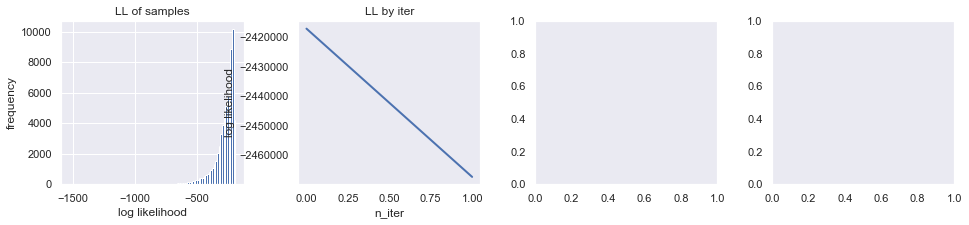

In [134]:
display_pca_data(n_components, decomp, BES_std)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


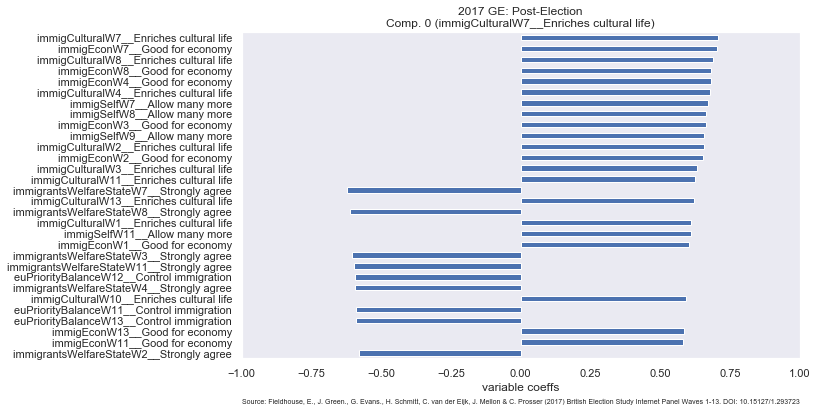

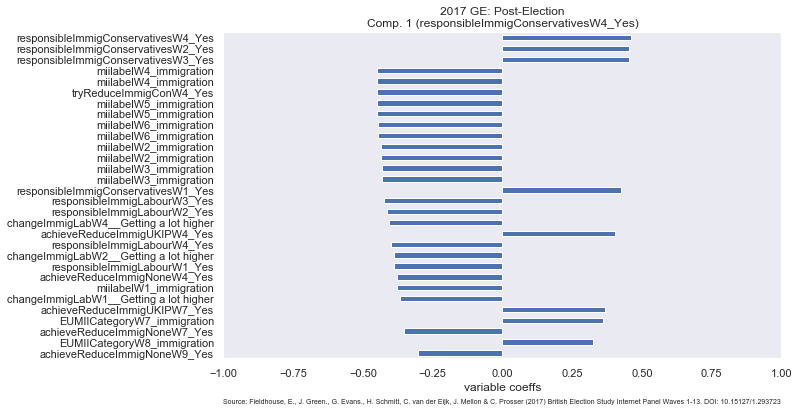

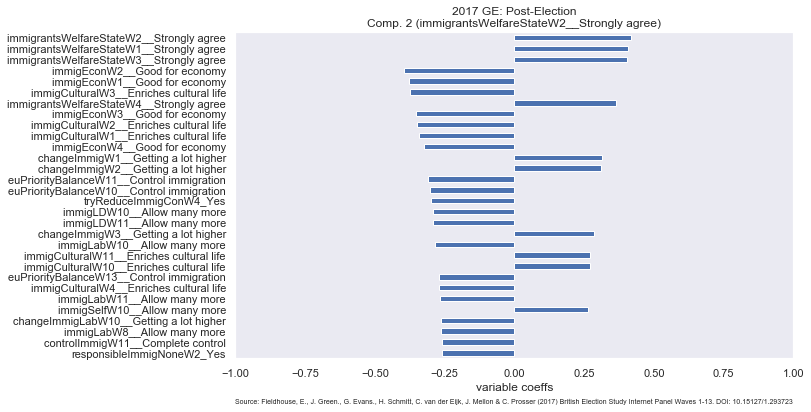

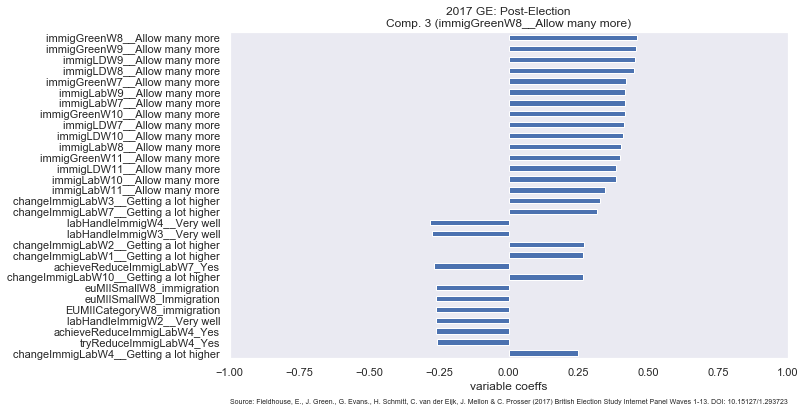

In [135]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_immig.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

,noise_variance_
euMIISmallW7_Immigration,0.328124
euMIISmallW7_immigration,0.328124
EUMIICategoryW7_immigration,0.329983
euMIISmallW8_Immigration,0.330531
euMIISmallW8_immigration,0.330531
...,...
controlImmigW8__Complete control,0.859318
immigSNPW8__Allow many more,0.888882
ukipPriorities_immigW9_Yes,0.909924
dv1ClassExpW2_Simmons,0.933690


,noise_variance_
dv1ClassExpW2_Simmons,0.933690
ukipPriorities2_immigW4_Yes,0.940316
ukipPriorities_immigW9_Yes,0.909924


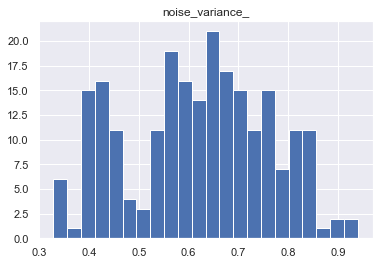

In [136]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

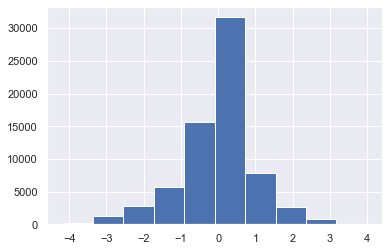

In [137]:
BES_decomp[0].hist()

In [138]:
# BES_export_to_R = BES_immig.apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [139]:
# try again with just the lowest noise variables
# immigEcon, immigCulturalm, immigSelf, immigrantsWelfareState, euPriorityBalance, 


In [140]:
BES_immig = BES_reduced[[x for x in BES_reduced.columns if re.match("immigEcon|immigCultural|immigSelf|immigrantsWelfareState|euPriorityBalance",x)]]

In [141]:
Treatment = dataset_name + "_immigration_narrower"

In [142]:
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [143]:
clean_feature_set_std = StandardScaler().fit_transform(BES_immig.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_immig.columns,
                             index   = BES_immig.index      )

In [144]:
%%time

n_components = BES_std.shape[1]

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_immig.index)

Wall time: 821 ms


In [145]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: -38.79405316918138
number of iterations: 2


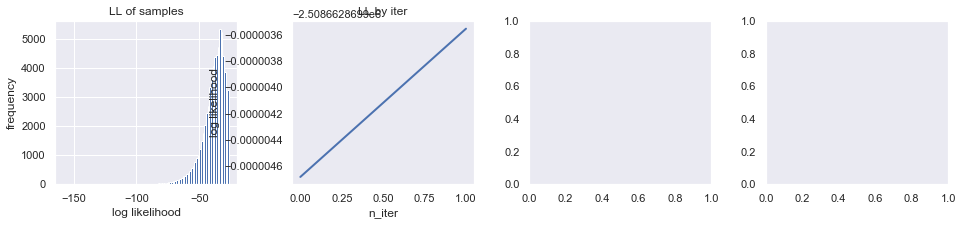

In [146]:
display_pca_data(n_components, decomp, BES_std)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


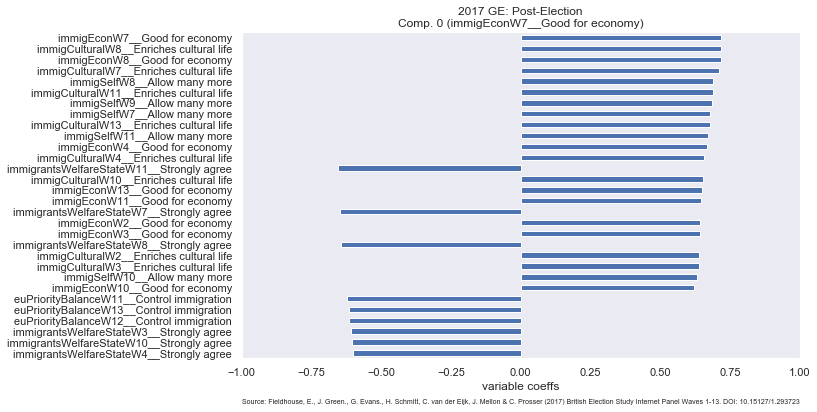

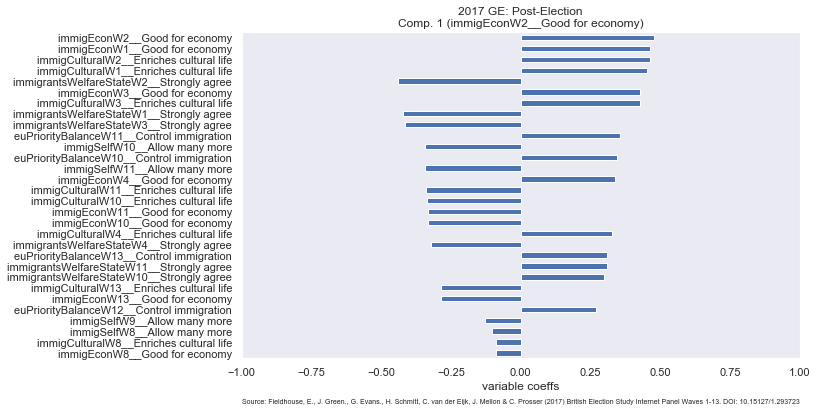

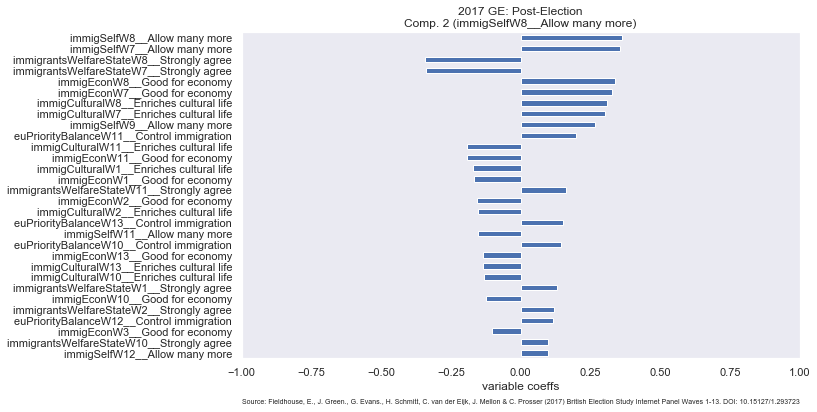

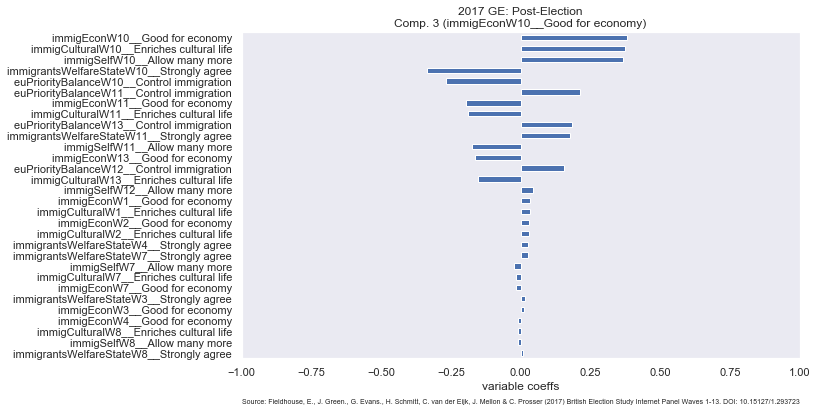

In [147]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_immig.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

,noise_variance_
immigEconW2__Good for economy,0.402314
immigCulturalW11__Enriches cultural life,0.407651
immigCulturalW2__Enriches cultural life,0.418766
immigCulturalW10__Enriches cultural life,0.430360
immigEconW8__Good for economy,0.431092
immigEconW7__Good for economy,0.433234
immigSelfW11__Allow many more,0.438053
immigCulturalW8__Enriches cultural life,0.440397
immigEconW3__Good for economy,0.443109
immigCulturalW3__Enriches cultural life,0.445564


,noise_variance_


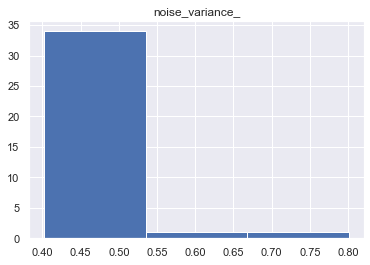

In [148]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [149]:
# BES_export_to_R = BES_immig.apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [150]:
hq_subset = BES_Panel[[x for x in BES_Panel.columns if re.match("immigEcon|immigCultural|immigSelf|immigrantsWelfareState|euPriorityBalance",x)]].notnull().sum(axis=1)>30

In [151]:
hq_subset.sum()

9138

In [152]:
# BES_export_to_R = BES_immig[hq_subset].apply(lambda x: x.astype('category'))
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.remove_unused_categories())
# BES_export_to_R = BES_export_to_R.apply(lambda x: x.cat.codes)
# BES_export_to_R = BES_export_to_R.replace(-1,np.nan)

# filename = Treatment+"_export_to_R"

# BES_export_to_R.to_stata(BES_R_data_files + filename + ".dta")
# display(filename)

In [153]:
# sankey diagram for imm_preferences?

In [154]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display, clear_output

In [155]:
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

In [156]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import display, clear_output

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru',
        'fuchsia', 'chartreuse']

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def make_sankey(BES, links, order, first_year, second_year, first_col, second_col,
                replace_dict, threshold, colour, fixed_order, scale, nodes, wt_col, groups, group_index):
    
    crosstab = pd.crosstab(index   = BES[ first_col  ],
                           columns = BES[ second_col ],
                           values  = BES[ wt_col ],
                           aggfunc = sum, dropna = False,
                           normalize=True)*scale

    if order == []: # initialise
        order = [ [[x+first_year]  for x in fixed_order] ]
    order.append( [[x+second_year] for x in fixed_order] ) # add new layer
    

    for col in crosstab.columns:
        if col not in replace_dict.keys():
            continue        
        second_party = replace_dict[ col ]
        for ind in crosstab[col].index:
            if ind not in replace_dict.keys():
                continue
            first_party = replace_dict[ ind ]
            
            if crosstab[col][ind]>threshold:
                if colour == []:
                    col_to_use = colourmap[first_party]
                else:
                    col_to_use = cmap[colour]
                
                node_id_first = first_party+first_year
                
                # add group if not already present
                if first_year not in group_index.keys():
                    group_index[first_year] = len(groups)
                    groups.append( {'id': first_year, 'title': first_year, 'nodes': []} )
                    
                if node_id_first not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_first, 'direction':'l'})
                    groups[group_index[first_year]]['nodes'].append(node_id_first)                    
                    
                node_id_second = second_party+second_year
                
                # add group if not already present
                if second_year not in group_index.keys():
                    group_index[second_year] = len(groups)
                    groups.append( {'id': second_year, 'title': second_year, 'nodes': []} )                
                
                if node_id_second not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_second, 'direction':'l'})
                    groups[group_index[second_year]]['nodes'].append(node_id_second)

                if colour ==[]:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use}
                else:
                    d = {'source': node_id_first,
                         'target': node_id_second,
                         'value': crosstab[col][ind],
                         'color': col_to_use,'type' : str(colour)}                    
                links.append(d)

    return links, order, nodes, groups, group_index

def sankify():
    colour = []
    order  = []
    links  = []
    # ["W7","W8","W9","W10","W11","W12","W13"]
    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}
    for pair_no in range(0,len(pairs)-1):


        (links, order, nodes, groups, group_index) = make_sankey(BES_Panel, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, fixed_order = base_order, scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale, layout=layout)
    return sankey

def sankify_init_col(): 
    # sankify with colour sets by initial choice

    colour = []
    order  = []
    links  = []

    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}

    for party in base_order:
        order  = []
        BES = BES_immig.loc[ BES_immig[immig_vars[0]]==party ]
        scale = 100 * BES.shape[0]/BES_immig.shape[0]
        colour = list(colourmap.values()).index( colourmap[replace_dict[party]] )    

        for pair_no in range(0,len(pairs)-1):

            (links, order, nodes, groups, group_index) = make_sankey(BES, links, order,
                                pairs[pair_no][0], pairs[pair_no+1][0],
                                pairs[pair_no][1], pairs[pair_no+1][1],
                                replace_dict, threshold, colour, fixed_order = base_order,
                                scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(layout=layout,links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale)
    return sankey

In [157]:
def sankify():
    colour = []
    order  = []
    links  = []
    # ["W7","W8","W9","W10","W11","W12","W13"]
    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}
    for pair_no in range(0,len(pairs)-1):


        (links, order, nodes, groups, group_index) = make_sankey(BES_Panel, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, fixed_order = base_order, scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale, layout=layout)
    return sankey

In [158]:
def sankify_init_col(): 
    # sankify with colour sets by initial choice

    colour = []
    order  = []
    links  = []

    pairs = [(x,im_var+x) for x in wave_list]
    scale = 100
    nodes = []
    wt_col = 'wt_new_W13'
    groups = []
    group_index = {}

    for party in base_order:
        order  = []
        BES = BES_immig.loc[ BES_immig[immig_vars[0]]==party ]
        scale = 100 * BES.shape[0]/BES_immig.shape[0]
        colour = list(colourmap.values()).index( colourmap[replace_dict[party]] )    

        for pair_no in range(0,len(pairs)-1):

            (links, order, nodes, groups, group_index) = make_sankey(BES, links, order,
                                pairs[pair_no][0], pairs[pair_no+1][0],
                                pairs[pair_no][1], pairs[pair_no+1][1],
                                replace_dict, threshold, colour, fixed_order = base_order,
                                scale=scale, nodes=nodes, wt_col = wt_col, groups=groups, group_index=group_index)    

    sankey = SankeyWidget(layout=layout,links=links, order=order, nodes=[], groups=groups, margins = margins, scale=diagram_scale)
    return sankey

In [159]:
im_var = "immigSelf"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

wave_list = ["W7","W8","W9","W10","W11"]

In [160]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', "Don't k…

In [161]:
BES_Panel[[x for x in BES_Panel.columns if "immigEcon" in x]].notnull().sum()

immigEconW1     30333
immigEconW2     30240
immigEconW3     28108
immigEconW4     31440
immigEconW7     30895
immigEconW8     33502
immigEconW10    30319
immigEconW11    31014
immigEconW13    31197
dtype: int64

In [162]:
BES_Panel[[x for x in BES_Panel.columns if "immigSelf" in x]].notnull().sum()

immigSelfW7     30895
immigSelfW8     33502
immigSelfW9     30036
immigSelfW10    30319
immigSelfW11    31014
immigSelfW12     9008
immigSelfW13     1292
dtype: int64

In [163]:
im_var = "immigEcon"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories


In [164]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankey = sankify()
sankey.auto_save_png(BES_output_folder+os.sep+"leftRight_sankey.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Bad for economyW1', '2W1', '3W1', '4W1', '5W1', "D…

In [165]:
BES_output_folder

'../BES_analysis_output/'

In [166]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"immigEcon.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Bad for economyW1', '2W1', '3W1', '4W1', '5W1', '6…

In [167]:
wave_list = ["W1","W13"]

threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Bad for economyW1', '2W1', '3W1', '4W1', '5W1', "D…

In [168]:
# now compared immigCultural
im_var = "immigCultural"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [169]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Undermines cultural lifeW1', '2W1', '3W1', '4W1', …

In [170]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Undermines cultural lifeW1', '2W1', '3W1', '4W1', …

In [171]:
# immigSelf W7W8W9W10W11W12W13
im_var = "immigSelf"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

# specific problem with the last two waves not overlapping the prior data!
wave_list = ['W7', 'W8', 'W9', 'W10', 'W11']

In [172]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', "Don't k…

In [173]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Allow many fewerW7', '1W7', '2W7', '3W7', '4W7', '…

In [174]:
#immigrantsWelfareState
im_var = "immigrantsWelfareState"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [175]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Strongly disagreeW1', 'DisagreeW1', 'Neither agree…

In [176]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
# sankify_init_col()
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"W13_comb_imm_corr"+os.sep+"immigrantsWelfareState.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Strongly disagreeW1', 'DisagreeW1', 'Neither agree…

In [177]:
# immigrationLevel
im_var = "immigrationLevel"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [178]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W4', 'title': 'W4', 'nodes': ['Decreased a lotW4', 'Decreased a littleW4', 'Left …

In [179]:
# immigContributeTake
# kind of a hassle because the categories are floats!

BES_Panel[[x for x in BES_Panel.columns if "immigContributeTake" in x]] = BES_Panel[[x for x in BES_Panel.columns if "immigContributeTake" in x]].apply(lambda x: x.cat.set_categories([str(x) for x in x.cat.categories]))



In [180]:
im_var = "immigContributeTake"

immig_vars = [x for x in BES_Panel.columns if im_var in x]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [181]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Pay more than they getW7', 'Get more than they pay…

In [182]:
# changeImmig
im_var = "changeImmig"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [183]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=180, right=180)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a little lowerW1', 'Staying about the same…

In [184]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=180, right=180)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankey = sankify_init_col()
sankey.auto_save_png(BES_output_folder+os.sep+"W13_comb_imm_corr"+os.sep+"changeImmig.png")

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot lowerW1', 'Getting a little lowerW1'…

In [185]:
# changeImmig
im_var = "changeImmigLab"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [186]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot higherW1', 'Getting a little lowerW1…

In [187]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['Getting a lot lowerW1', 'Getting a little lowerW1'…

In [188]:
# controlImmig
im_var = "controlImmig"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [189]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W8', 'title': 'W8', 'nodes': ['No control at allW8', 'A little controlW8', 'Some …

In [190]:
threshold = 0.01
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=20
sankify_init_col()

SankeyWidget(groups=[{'id': 'W8', 'title': 'W8', 'nodes': ['No control at allW8', 'A little controlW8', 'Some …

In [191]:
# asylum, eu, noneu, students, families

In [192]:
im_var = "asylumMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [193]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [194]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [195]:
im_var = "euMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [196]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [197]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [198]:
im_var = "noneuMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [199]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [200]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [201]:
im_var = "studentsMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [202]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [203]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [204]:
im_var = "familiesMore"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [205]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [206]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Many fewerW7', '1W7', '2W7', '3W7', '4W7', '5W7', …

In [207]:
# effectsEUImmigration

In [208]:
im_var = "effectsEUImmigration"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [209]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Much lowerW7', 'LowerW7', 'About the sameW7', 'Muc…

In [210]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['Much lowerW7', 'LowerW7', 'About the sameW7', 'Hig…

In [211]:
# euPriorityBalance

In [212]:
im_var = "euPriorityBalance"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [213]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W10', 'title': 'W10', 'nodes': ['Access to the single marketW10', '1W10', '2W10',…

In [214]:
threshold = 0.01
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W10', 'title': 'W10', 'nodes': ['Access to the single marketW10', '1W10', '2W10',…

In [215]:
# euMIISmall

In [216]:
# len(BES_immig[immig_vars[0]].cat.categories)

In [217]:
# euMIISmall
im_var = "euMIISmall"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories

In [218]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W7', 'title': 'W7', 'nodes': ['ImmigrationW7', 'EconomyW7', 'British/english iden…

In [219]:
# EUMIICategory
# 54 categories - too many!

In [220]:
# miilabel
len(BES_immig[immig_vars[0]].cat.categories)

15

In [221]:
im_var = "miilabel"

immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
wave_list = [x.split(im_var)[1] for x in immig_vars]
immig_vars_minus_wt_col = immig_vars.copy()
immig_vars.append('wt_new_W13')
BES_immig = BES_Panel[immig_vars]

In [222]:
var_list=  []
for ind in range(0,len(immig_vars_minus_wt_col)):
    vc = BES_immig[immig_vars_minus_wt_col[ind]].value_counts()
    sig_var = vc[vc/vc.sum()>.03].index
    [var_list.append(x) for x in sig_var if x not in var_list]
var_list

['economy general',
 'immigration',
 "Don't know",
 'flooding',
 'unemployment',
 'poverty, living stds',
 'scot const',
 'europe',
 'nhs',
 'terrorism',
 'international probs',
 'services-spending',
 'social inequalities',
 'politics-neg']

In [223]:
ordered_by_freq = var_list
#BES_immig[immig_vars_minus_wt_col].stack().value_counts().index
temp = list(ordered_by_freq[0:12])
temp.append("Other")

for x in immig_vars_minus_wt_col:
    BES_immig[x] = BES_immig[x].cat.set_categories(temp)#.fillna("Other")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [224]:
replace_dict = {x:x for x in BES_immig[immig_vars[0]].cat.categories}
colourmap = {BES_immig[immig_vars[0]].cat.categories[x]:cmap[x] for x in range(0, len( BES_immig[immig_vars[0]].cat.categories)) } 
base_order = BES_immig[immig_vars[0]].cat.categories#.drop("Other")

In [225]:
threshold = 0.5
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=2
sankify()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['unemploymentW1', 'economy generalW1', "Don't knowW…

In [226]:
threshold = 0.1
margins=dict(top=30, bottom=10, left=150, right=150)
layout = Layout(width="1000", height="650")
diagram_scale=5
sankify_init_col()

SankeyWidget(groups=[{'id': 'W1', 'title': 'W1', 'nodes': ['economy generalW1', 'immigrationW1', "Don't knowW1…

In [227]:
# 

In [228]:
imvar_list = ["immigEcon","immigCultural", "immigSelf",
             "immigrationLevel", "immigContributeTake",
             "immigrantsWelfareState", "controlImmig",
             "effectsEUImmigration", "euPriorityBalance",
             "changeImmig", "changeImmigLab",
             "govtHandleImmig", "labHandleImmig",
             "asylumMore", "euMore", "noneuMore", "studentsMore", "familiesMore"]

In [229]:
# np.empty( (10,10) )
number_of_waves = 13
imvars_by_waves = pd.DataFrame(np.full( ( len(imvar_list),number_of_waves), np.nan),
                  columns = ["W"+str(x) for x in range(1,number_of_waves+1)],
                  index = imvar_list ).T

In [231]:
#BES_Panel[immig_vars[0]].cat.codes.max()
# max_range

In [232]:
for im_var in imvar_list:
    immig_vars = [x for x in BES_Panel.columns if re.match(im_var+"W\d",  x)]
    wave_list = [x.split(im_var)[1] for x in immig_vars]

    BES_immig = BES_Panel[immig_vars].replace("Don't know",np.nan).apply(lambda x: x.cat.codes).replace(-1,np.nan)
#     print(immig_vars, wave_list)
    max_range = len(BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore'))-1
    print(immig_vars[0], max_range)
    for wave in wave_list:
        wt_new = "wt_new_"+wave
        wt_old = "wt_full_"+wave
        if wt_new in BES_Panel.columns:
            wt = BES_Panel[wt_new]
        else:
            wt = BES_Panel[wt_old]
        imvars_by_waves.loc[wave,im_var] = (BES_immig[im_var+wave].multiply(wt).mean())/max_range
        
    top_cat = BES_Panel[immig_vars[0]].cat.categories.drop("Don't know",errors='ignore')[-1]
    imvars_by_waves.rename(index=str, columns={im_var: im_var + "_" + top_cat}, inplace=True)

imvars_by_waves

immigEconW1 6
immigCulturalW1 6
immigSelfW7 10
immigrationLevelW4 4
immigContributeTakeW7 6
immigrantsWelfareStateW1 4
controlImmigW8 4
effectsEUImmigrationW7 4
euPriorityBalanceW10 10
changeImmigW1 4
changeImmigLabW1 4
govtHandleImmigW1 4
labHandleImmigW1 4
asylumMoreW7 10
euMoreW7 10
noneuMoreW7 10
studentsMoreW7 10
familiesMoreW7 10


,immigEcon_Good for economy,immigCultural_Enriches cultural life,immigSelf_Allow many more,immigrationLevel_Increased a lot,immigContributeTake_Get more than they pay,immigrantsWelfareState_Strongly agree,controlImmig_Complete control,effectsEUImmigration_Much higher,euPriorityBalance_Control immigration,changeImmig_Getting a lot higher,changeImmigLab_Getting a lot higher,govtHandleImmig_Very well,labHandleImmig_Very well,asylumMore_Many more,euMore_Many more,noneuMore_Many more,studentsMore_Many more,familiesMore_Many more
W1,0.422969,0.405089,NaN,NaN,NaN,0.619937,NaN,NaN,NaN,0.744253,0.644485,0.380639,0.414651,NaN,NaN,NaN,NaN,NaN
W2,0.424609,0.409209,NaN,NaN,NaN,0.643482,NaN,NaN,NaN,0.731656,0.630306,0.342947,0.403055,NaN,NaN,NaN,NaN,NaN
W3,0.401930,0.393543,NaN,NaN,NaN,0.669404,NaN,NaN,NaN,0.762521,0.652189,0.273102,0.325407,NaN,NaN,NaN,NaN,NaN
W4,0.457556,0.432202,NaN,0.217151,NaN,0.620283,NaN,NaN,NaN,0.773037,0.643577,0.271421,0.348061,NaN,NaN,NaN,NaN,NaN
W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W6,NaN,NaN,NaN,0.235075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W7,0.450405,0.414961,0.294593,NaN,0.779524,0.631499,NaN,0.344286,NaN,0.793386,0.686475,0.239651,0.337831,0.312620,0.364955,0.316704,0.428538,0.372131
W8,0.461082,0.428667,0.297304,NaN,0.720357,0.624870,0.316654,0.338188,NaN,0.792248,NaN,NaN,NaN,0.318247,0.366504,0.338750,0.438382,0.362413
W9,NaN,NaN,0.314482,NaN,NaN,NaN,0.508021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W10,0.510847,0.458711,0.296479,NaN,NaN,0.550885,0.494319,0.365133,0.524150,0.656667,0.632893,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
len(set(imvars_by_waves.columns))

18

In [234]:
# imvars_by_waves.index[imvars_by_waves[imvar].isnull()]

In [235]:
# # multiple line plot
# # create a color palette
# palette = plt.get_cmap('Set1')
# # style
# plt.style.use('seaborn-darkgrid')
# f = plt.figure(figsize=(10,10))

# num=1
# for imvar in imvars_by_waves.columns:
# #     plt.plot( imvars_by_waves.index, imvars_by_waves[imvar], color=palette(num))
#     g = sns.pointplot(imvars_by_waves.index, imvars_by_waves[imvar], color =cmap[num%(len(cmap))], label = imvar)
# # plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
# # plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
#     num=num+1
# g.legend();


In [247]:
# wave_dates.loc[3]

In [248]:
wave_dates = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")
wave_dates = wave_dates.sort_index()
wave_dates = wave_dates["Date_Start"].apply(lambda x: pd.to_datetime(x))

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-02-14 00:00:00

IndexError: boolean index did not match indexed array along dimension 0; dimension is 16 but corresponding boolean dimension is 13

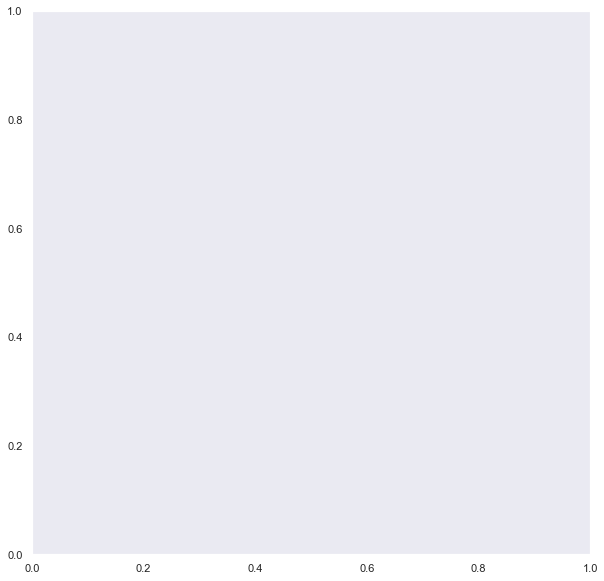

In [238]:
# date = pd.date_range("2017-03", freq="M", periods=15)
# count = np.random.rand(15,4)
# df1 = pd.DataFrame({"date":date, "count" : count[:,0]})
# df2 = pd.DataFrame({"date":date, "count" : count[:,1]+0.7})
# df3 = pd.DataFrame({"date":date, "count" : count[:,2]+2})

f, ax = plt.subplots(1, 1, figsize=(10,10))
# x_col='date'
# y_col = 'count'
num=1
for imvar in imvars_by_waves.columns:
    notnull_vals = imvars_by_waves[imvar].notnull()
    if num<=10:
        marker = 'o'
    else:
        marker = 'v'
    
    ax.plot_date(wave_dates.values[notnull_vals],
                 imvars_by_waves[imvar][notnull_vals],
                 color=cmap[num%len(cmap)],
                 label=imvar,
                 linestyle="-",
                 marker = marker)
    num = num +1
# ax.plot_date(wave_dates, df2["count"], color="red", label="B", linestyle="-")
# ax.plot_date(wave_dates, df3["count"], color="green", label="C", linestyle="-")

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# legend(loc="upper left", bbox_to_anchor=(1,1))

plt.gcf().autofmt_xdate()
plt.axvline(x=wave_dates.loc[3], alpha=.9)
plt.text(wave_dates.loc[3],.8,'Peak UKIP (post EU elec.)',rotation=45)
plt.axvline(x=wave_dates.loc[8], alpha=.9)
plt.text(wave_dates.loc[8],.8,'2016 EU referendum',rotation=45)

dataset_citation = "Source: " + manifest["Citation"].values[0]
plt.annotate(dataset_citation, (0,0), (0, -40),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)  

Treatment = "W13_comb_imm_corr"
plt.savefig(BES_output_folder+ Treatment + os.sep + "Immigration_variables_by_waves.png",bbox_inches='tight');
plt.show()

In [249]:
# LDA on voters who switched/stayed
# easier imm variables - immigEcon/immigCultural
# W8 -> W10

In [250]:
[ x for x in BES_Panel.columns if "immigEcon" in x]

['immigEconW1',
 'immigEconW2',
 'immigEconW3',
 'immigEconW4',
 'immigEconW7',
 'immigEconW8',
 'immigEconW10',
 'immigEconW11',
 'immigEconW13']

In [251]:
ImmBadW8 = (BES_Panel["immigEconW3"]=='Bad for economy') & (BES_Panel["immigEconW4"].notnull())
ChangedMind = BES_Panel[ImmBadW8]["immigEconW4"] != 'Bad for economy'
ChangedMind.value_counts()

False    3015
True     2047
Name: immigEconW4, dtype: int64

In [252]:
ImmBadW8 = (BES_Panel["immigEconW8"]=='Bad for economy') & (BES_Panel["immigEconW10"].notnull())
ChangedMind = BES_Panel[ImmBadW8]["immigEconW10"] != 'Bad for economy'
ChangedMind.value_counts()
# pretty distinct!

False    1773
True     1725
Name: immigEconW10, dtype: int64

In [253]:
BES_imm = BES_reduced[ImmBadW8]
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigEcon" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigCultural" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigSelf" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "immigrantsWelfareState" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "euPriorityBalance" in x] , axis=1)
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "UKIP" in x] , axis=1)

# immigrantsWelfareState, UKIP, euPriorityBalance, immigSelf
# weird stuff about passport variables!
# BES_imm = BES_imm.drop([x for x in BES_imm.columns if "passport" in x] , axis=1)

In [254]:
Treatment = "AntiImmigrantThaw"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [255]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [256]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_imm.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_imm.columns,
                             index   = BES_imm.index      )

In [257]:
%%time
n_components = BES_std.shape[1]
n_components = 1

decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 

X_r = decomp.fit_transform(BES_std, ChangedMind)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_imm.index)

Wall time: 3min 6s


In [258]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "LinearDiscriminatAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
#     BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
#     BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

Warning, filename truncated because it was over 30. Filenames may no longer be unique


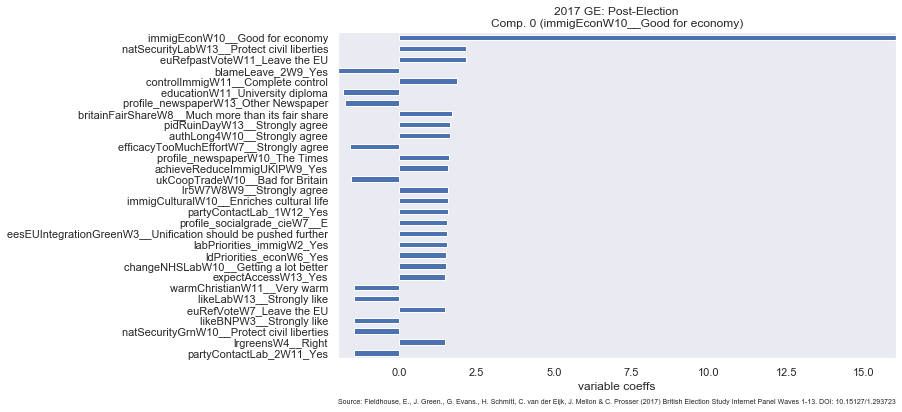

In [259]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_imm.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [260]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=100):
#     cols = X.columns
#     variables = np.arange(X.shape[1])
#     dropped=True
#     while dropped:
#         dropped=False
#         c = X[cols[variables]].values
#         vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
#             variables = np.delete(variables, maxloc)
#             dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X[cols[variables]]

In [261]:
gc.collect()

5451

In [262]:
# imm_corr = BES_imm.corrwith(ChangedMind).sort_values().dropna()
# imm_corr

In [263]:
imm_corr = BES_imm.corrwith(ChangedMind).sort_values().dropna()
imm_corr

immigrantsWelfareStateW10__Strongly agree   -0.257794
euPriorityBalanceW10__Control immigration   -0.247943
euPriorityBalanceW13__Control immigration   -0.225594
overseasAidW10__Strongly agree              -0.211205
euPriorityBalanceW11__Control immigration   -0.205929
                                               ...   
immigCulturalW11__Enriches cultural life     0.256869
immigEconW13__Good for economy               0.303069
immigEconW11__Good for economy               0.333705
immigCulturalW10__Enriches cultural life     0.460466
immigEconW10__Good for economy               0.793556
Length: 5632, dtype: float64

In [264]:
imm_corr[[x for x in imm_corr.index if "euRef" in x]]

euRefVoteW10_Leave the EU                                           -0.122308
euRefVoteW13_Leave the EU                                           -0.117609
euRefVoteW11_Leave the EU                                           -0.108373
euRefpastVoteW13_Leave the EU                                       -0.099441
euRefVoteUnsqueezeW7_Leave the EU                                   -0.098102
euRefVoteW9_Leave the EU                                            -0.096662
euRefVoteW7_Leave the EU                                            -0.093827
euRefpastVoteW11_Leave the EU                                       -0.086466
euRefExpectationW8__100 - UK will definitely vote to leave the EU   -0.080740
euRefVoteW12_Leave the EU                                           -0.077713
euRefpastVoteW12_Leave the EU                                       -0.077145
euRefCertaintyW8__Completely certain                                -0.071148
euRefVoteW6_Leave the EU                                        

In [265]:
# realignment by social conservatism?

In [266]:
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x or "al_scale" in x] ].corr()

,immigEconW1__Good for economy,immigEconW2__Good for economy,immigEconW3__Good for economy,immigEconW4__Good for economy,immigEconW7__Good for economy,immigEconW8__Good for economy,immigEconW10__Good for economy,immigEconW11__Good for economy,immigEconW13__Good for economy,al_scaleW7W8W9__Authoritarian,al_scaleW6__Authoritarian,al_scaleW1W2W3W4W5__Authoritarian,al_scaleW10W11W12__Authoritarian,al_scaleW13__Authoritarian
immigEconW1__Good for economy,1.000000,0.695127,0.591534,0.533190,0.406186,0.356388,0.253847,0.266687,0.278551,-0.284829,-0.372964,-0.428005,-0.189476,-0.228354
immigEconW2__Good for economy,0.695127,1.000000,0.660007,0.587382,0.447526,0.397511,0.281210,0.296350,0.308468,-0.312545,-0.409248,-0.443881,-0.207515,-0.250616
immigEconW3__Good for economy,0.591534,0.660007,1.000000,0.623561,0.462402,0.405002,0.286089,0.306752,0.320280,-0.324160,-0.432727,-0.429591,-0.220910,-0.262163
immigEconW4__Good for economy,0.533190,0.587382,0.623561,1.000000,0.522388,0.460262,0.328855,0.349333,0.361681,-0.343014,-0.476868,-0.436837,-0.225328,-0.276425
immigEconW7__Good for economy,0.406186,0.447526,0.462402,0.522388,1.000000,0.617996,0.427184,0.440932,0.447951,-0.485098,-0.366996,-0.316867,-0.291000,-0.328659
immigEconW8__Good for economy,0.356388,0.397511,0.405002,0.460262,0.617996,1.000000,0.461141,0.471170,0.481693,-0.497646,-0.331233,-0.289647,-0.313930,-0.357924
immigEconW10__Good for economy,0.253847,0.281210,0.286089,0.328855,0.427184,0.461141,1.000000,0.514852,0.486533,-0.296923,-0.219460,-0.182891,-0.469484,-0.338145
immigEconW11__Good for economy,0.266687,0.296350,0.306752,0.349333,0.440932,0.471170,0.514852,1.000000,0.615536,-0.305382,-0.241020,-0.213365,-0.346467,-0.374551
immigEconW13__Good for economy,0.278551,0.308468,0.320280,0.361681,0.447951,0.481693,0.486533,0.615536,1.000000,-0.318828,-0.256960,-0.227808,-0.347744,-0.492994
al_scaleW7W8W9__Authoritarian,-0.284829,-0.312545,-0.324160,-0.343014,-0.485098,-0.497646,-0.296923,-0.305382,-0.318828,1.000000,0.538940,0.474352,0.472219,0.528065


In [267]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigCultural" in x] ].corrwith(al_lazy, drop=True)

immigCulturalW1__Enriches cultural life    -0.401105
immigCulturalW2__Enriches cultural life    -0.428428
immigCulturalW3__Enriches cultural life    -0.444137
immigCulturalW4__Enriches cultural life    -0.452568
immigCulturalW7__Enriches cultural life    -0.465515
immigCulturalW8__Enriches cultural life    -0.463761
immigCulturalW10__Enriches cultural life   -0.415298
immigCulturalW11__Enriches cultural life   -0.419816
immigCulturalW13__Enriches cultural life   -0.458917
dtype: float64

In [269]:
al2 = BES_reduced[ [x for x in BES_reduced if "al2" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigCultural" in x] ].corrwith(al2, drop=True)

immigCulturalW1__Enriches cultural life    -0.357533
immigCulturalW2__Enriches cultural life    -0.381372
immigCulturalW3__Enriches cultural life    -0.406699
immigCulturalW4__Enriches cultural life    -0.406429
immigCulturalW7__Enriches cultural life    -0.417367
immigCulturalW8__Enriches cultural life    -0.417669
immigCulturalW10__Enriches cultural life   -0.377140
immigCulturalW11__Enriches cultural life   -0.387671
immigCulturalW13__Enriches cultural life   -0.424933
dtype: float64

In [270]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x] ].corrwith(al_lazy, drop=True)

immigEconW1__Good for economy    -0.398340
immigEconW2__Good for economy    -0.429706
immigEconW3__Good for economy    -0.441013
immigEconW4__Good for economy    -0.463891
immigEconW7__Good for economy    -0.472300
immigEconW8__Good for economy    -0.472530
immigEconW10__Good for economy   -0.394156
immigEconW11__Good for economy   -0.387946
immigEconW13__Good for economy   -0.429837
dtype: float64

In [271]:
al2 = BES_reduced[ [x for x in BES_reduced if "al2" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigEcon" in x] ].corrwith(al2, drop=True)

immigEconW1__Good for economy    -0.352589
immigEconW2__Good for economy    -0.384233
immigEconW3__Good for economy    -0.388515
immigEconW4__Good for economy    -0.419218
immigEconW7__Good for economy    -0.426736
immigEconW8__Good for economy    -0.424088
immigEconW10__Good for economy   -0.360989
immigEconW11__Good for economy   -0.350787
immigEconW13__Good for economy   -0.379906
dtype: float64

In [272]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigSelf" in x] ].corrwith(al_lazy, drop=True)

immigSelfW7__Allow many more    -0.488440
immigSelfW8__Allow many more    -0.490690
immigSelfW9__Allow many more    -0.479544
immigSelfW10__Allow many more   -0.438655
immigSelfW11__Allow many more   -0.448361
immigSelfW12__Allow many more   -0.195280
dtype: float64

In [273]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "immigrantsWelfareState" in x] ].corrwith(al_lazy, drop=True)

immigrantsWelfareStateW1__Strongly agree     0.430926
immigrantsWelfareStateW2__Strongly agree     0.459918
immigrantsWelfareStateW3__Strongly agree     0.494324
immigrantsWelfareStateW4__Strongly agree     0.498308
immigrantsWelfareStateW7__Strongly agree     0.502103
immigrantsWelfareStateW8__Strongly agree     0.498740
immigrantsWelfareStateW10__Strongly agree    0.454696
immigrantsWelfareStateW11__Strongly agree    0.465719
dtype: float64

In [274]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "controlImmig" in x] ].corrwith(al_lazy, drop=True)

controlImmigW8__Complete control    -0.174120
controlImmigW9__Complete control     0.312973
controlImmigW10__Complete control    0.238909
controlImmigW11__Complete control    0.277300
controlImmigW13__Complete control    0.290850
dtype: float64

In [275]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "effectsEUImmigration" in x] ].corrwith(al_lazy, drop=True)

effectsEUImmigrationW7__Much higher    -0.154590
effectsEUImmigrationW8__Much higher    -0.197250
effectsEUImmigrationW10__Much higher   -0.159775
effectsEUImmigrationW11__Much higher   -0.188844
effectsEUImmigrationW13__Much higher   -0.187042
dtype: float64

In [276]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "euPriorityBalance" in x] ].corrwith(al_lazy, drop=True)

euPriorityBalanceW10__Control immigration    0.418127
euPriorityBalanceW11__Control immigration    0.430515
euPriorityBalanceW12__Control immigration    0.456213
euPriorityBalanceW13__Control immigration    0.466053
dtype: float64

In [277]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "changeImmig" in x] ].corrwith(al_lazy, drop=True)

changeImmigW1__Getting a lot higher        0.340256
changeImmigLabW1__Getting a lot higher     0.152902
changeImmigW2__Getting a lot higher        0.362274
changeImmigLabW2__Getting a lot higher     0.168036
changeImmigW3__Getting a lot higher        0.379407
changeImmigLabW3__Getting a lot higher     0.199342
changeImmigW4__Getting a lot higher        0.351321
changeImmigLabW4__Getting a lot higher     0.159630
changeImmigW7__Getting a lot higher        0.396629
changeImmigLabW7__Getting a lot higher     0.205376
changeImmigW8__Getting a lot higher        0.377097
changeImmigW10__Getting a lot higher       0.221762
changeImmigLabW10__Getting a lot higher    0.191539
changeImmigW11__Getting a lot higher       0.229793
dtype: float64

In [278]:
al_lazy = BES_reduced[ [x for x in BES_reduced if "al_scale" in x] ].mean(axis=1)
BES_reduced[ [x for x in BES_reduced if "euMore" in x] ].corrwith(al_lazy, drop=True)

euMoreW7__Many more       -0.392832
noneuMoreW7__Many more    -0.363304
euMoreW8__Many more       -0.393260
noneuMoreW8__Many more    -0.333993
euMoreW13__Many more      -0.341854
noneuMoreW13__Many more   -0.320474
dtype: float64

In [279]:
all_corr = BES_reduced.corrwith(al_lazy, drop=True)

In [280]:
all_corr.drop([x for x in BES_reduced.columns if "al" in x]).sort_values()

immigSelfW8__Allow many more               -0.490690
immigSelfW7__Allow many more               -0.488440
asylumMoreW13__Many more                   -0.481365
asylumMoreW8__Many more                    -0.480056
asylumMoreW7__Many more                    -0.479935
                                              ...   
overseasAidW11__Strongly agree              0.473962
immigrantsWelfareStateW3__Strongly agree    0.494324
immigrantsWelfareStateW4__Strongly agree    0.498308
immigrantsWelfareStateW8__Strongly agree    0.498740
immigrantsWelfareStateW7__Strongly agree    0.502103
Length: 4569, dtype: float64

In [281]:
# add these later!
[x for x in BES_Panel.columns if "More" in x]

['asylumMoreW7',
 'euMoreW7',
 'noneuMoreW7',
 'studentsMoreW7',
 'familiesMoreW7',
 'asylumMoreW8',
 'euMoreW8',
 'noneuMoreW8',
 'studentsMoreW8',
 'familiesMoreW8',
 'asylumMoreW13',
 'euMoreW13',
 'noneuMoreW13',
 'studentsMoreW13',
 'familiesMoreW13']